<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/core_methods/continous_fixed_time_dgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.7 MB/s eta 0:00:00


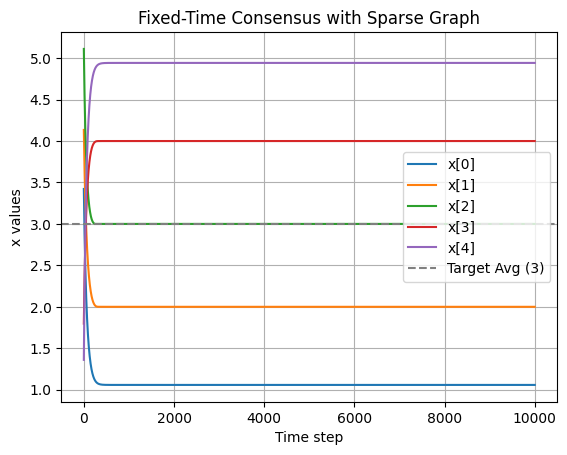

Final x: [1.05835  2.000355 3.000006 3.999645 4.94165 ]


In [2]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

# --- Sign function with power ---
def sgn(gamma, x):
    return np.sign(x) * (np.abs(x) ** gamma)

# --- Parameters ---
n = 5
a = np.array([1, 2, 3, 4, 5], dtype=float)  # Target positions
x = np.random.uniform(0, 6, size=n)         # Initial states

alpha1, alpha2 = 1.0, 1.0
gamma1, gamma2 = 0.5, 1.5
dt = 0.005
steps = 10000

# --- Create a connected sparse graph ---
g = ig.Graph.Tree(5, 1)  # Tree ensures connectedness
assert g.is_connected()

# --- Compute Metropolis weights ---
degrees = g.degree()
W = np.zeros((n, n))
for i in range(n):
    neighbors = g.neighbors(i)
    for j in neighbors:
        W[i, j] = 1 / (1 + max(degrees[i], degrees[j]))
    W[i, i] = 1 - np.sum(W[i])  # Ensure row stochastic

# --- Simulation loop ---
history = [x.copy()]
for _ in range(steps):
    x_next = x.copy()
    for i in range(n):
        grad = x[i] - a[i]
        s1 = sgn(gamma1, grad)
        s2 = sgn(gamma2, grad)
        consensus = sum(W[i, j] * (x[i] - x[j]) for j in g.neighbors(i))
        dx = -grad - alpha1 * s1 - alpha2 * s2 - consensus
        x_next[i] += dt * dx
    x = x_next
    history.append(x.copy())

# --- Plot ---
history = np.array(history)
for i in range(n):
    plt.plot(history[:, i], label=f'x[{i}]')
plt.axhline(3, color='gray', linestyle='--', label='Target Avg (3)')
plt.title("Fixed-Time Consensus with Sparse Graph")
plt.xlabel("Time step")
plt.ylabel("x values")
plt.legend()
plt.grid(True)
plt.show()

# --- Final values ---
print("Final x:", x.round(6))


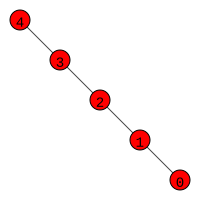

In [3]:
ig.plot(g,bbox=(0,0,200,200), vertex_label=np.arange(5))

Simulating on Fully Connected graph...


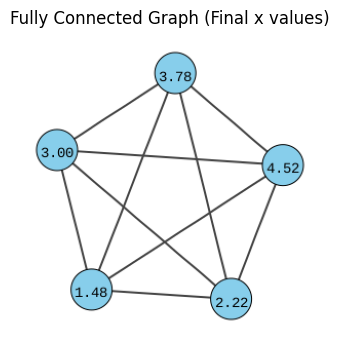

Final x values for Fully Connected: [1.484126 2.216999 3.000007 3.783473 4.516353]

Simulating on Ring graph...


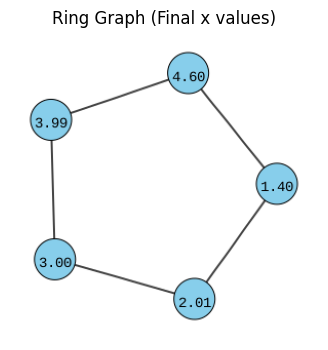

Final x values for Ring: [1.396492 2.012228 3.000006 3.987859 4.604345]

Simulating on Tree graph...


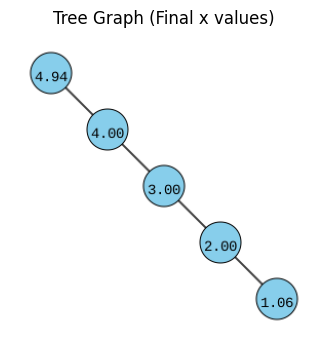

Final x values for Tree: [1.05892  2.000363 2.999994 3.999647 4.941796]



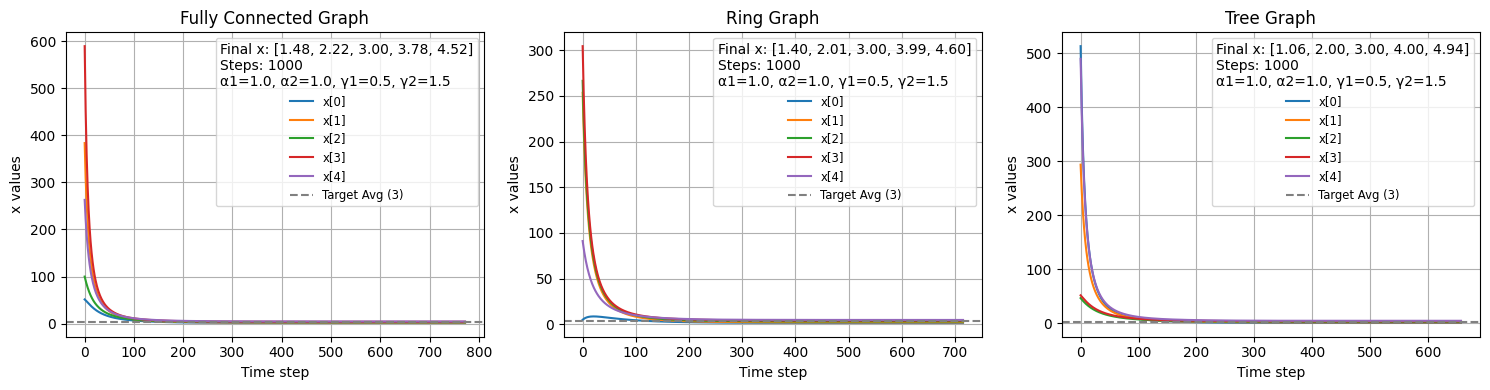

In [4]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import tempfile
import os
from PIL import Image

def sgn(gamma, x):
    return np.sign(x) * (np.abs(x) ** gamma)

n = 5
a = np.array([1, 2, 3, 4, 5], dtype=float)
alpha1, alpha2 = 1.0, 1.0
gamma1, gamma2 = 0.5, 1.5
dt = 0.005
steps = 1000

def metropolis_weights(g):
    degrees = g.degree()
    W = np.zeros((n, n))
    for i in range(n):
        neighbors = g.neighbors(i)
        for j in neighbors:
            W[i, j] = 1 / (1 + max(degrees[i], degrees[j]))
        W[i, i] = 1 - np.sum(W[i])
    return W

def simulate_consensus(g, graph_name):
    x = np.random.uniform(0, 6, size=n)*100
    W = metropolis_weights(g)
    history = [x.copy()]
    for _ in range(steps):
        x_next = x.copy()
        for i in range(n):
            grad = x[i] - a[i]
            s1 = sgn(gamma1, grad)
            s2 = sgn(gamma2, grad)
            consensus = sum(W[i, j] * (x[i] - x[j]) for j in g.neighbors(i))
            dx = -grad - alpha1 * s1 - alpha2 * s2 - consensus
            x_next[i] += dt * dx
        x = x_next
        history.append(x.copy())
        if np.average(np.std(history[-10:], axis=0)) < 1e-5:
          break
    history = np.array(history)
    final_vals = x.round(6)

    # igraph plot with labels, save to temp file and display inline
    layout = g.layout("kk")
    tmpfile = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    ig.plot(
        g,
        target=tmpfile.name,
        layout=layout,
        vertex_label=[f"{v:.2f}" for v in final_vals],
        vertex_size=40,
        vertex_color="skyblue",
        edge_width=2,
        bbox=(300, 300),
        margin=40,
    )
    # Display the saved image inline
    img = Image.open(tmpfile.name)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{graph_name} Graph (Final x values)")
    plt.show()
    os.unlink(tmpfile.name)  # delete temp file

    print(f"Final x values for {graph_name}: {final_vals}")
    return history, final_vals

graphs = {
    "Fully Connected": ig.Graph.Full(n),
    "Ring": ig.Graph.Ring(n),
    "Tree": ig.Graph.Tree(n, 1, mode=ig.TREE_UNDIRECTED),
}

histories = {}
final_vals = {}

for name, graph in graphs.items():
    print(f"Simulating on {name} graph...")
    h, f = simulate_consensus(graph, name)
    histories[name] = h
    final_vals[name] = f
    print()

# Plot convergence curves with final x and params in legend
plt.figure(figsize=(15, 4))
for i, (name, history) in enumerate(histories.items()):
    plt.subplot(1, 3, i+1)
    for node in range(n):
        plt.plot(history[:, node], label=f"x[{node}]")
    plt.axhline(3, color='gray', linestyle='--', label='Target Avg (3)')
    plt.title(f"{name} Graph")
    plt.xlabel("Time step")
    plt.ylabel("x values")
    plt.grid(True)
    final_str = ', '.join([f"{v:.2f}" for v in final_vals[name]])
    plt.legend(title=f"Final x: [{final_str}]\nSteps: {steps}\nα1={alpha1}, α2={alpha2}, γ1={gamma1}, γ2={gamma2}",
               fontsize='small', loc='upper right')
plt.tight_layout()
plt.show()


In [5]:
std_per_node = np.average(np.std(histories['Ring'][-10:], axis=0))
std_per_node, std_per_node < 1e-5

# calcluatent length of each historytype
for history in histories.values():
  print(len(history))

773
716
658


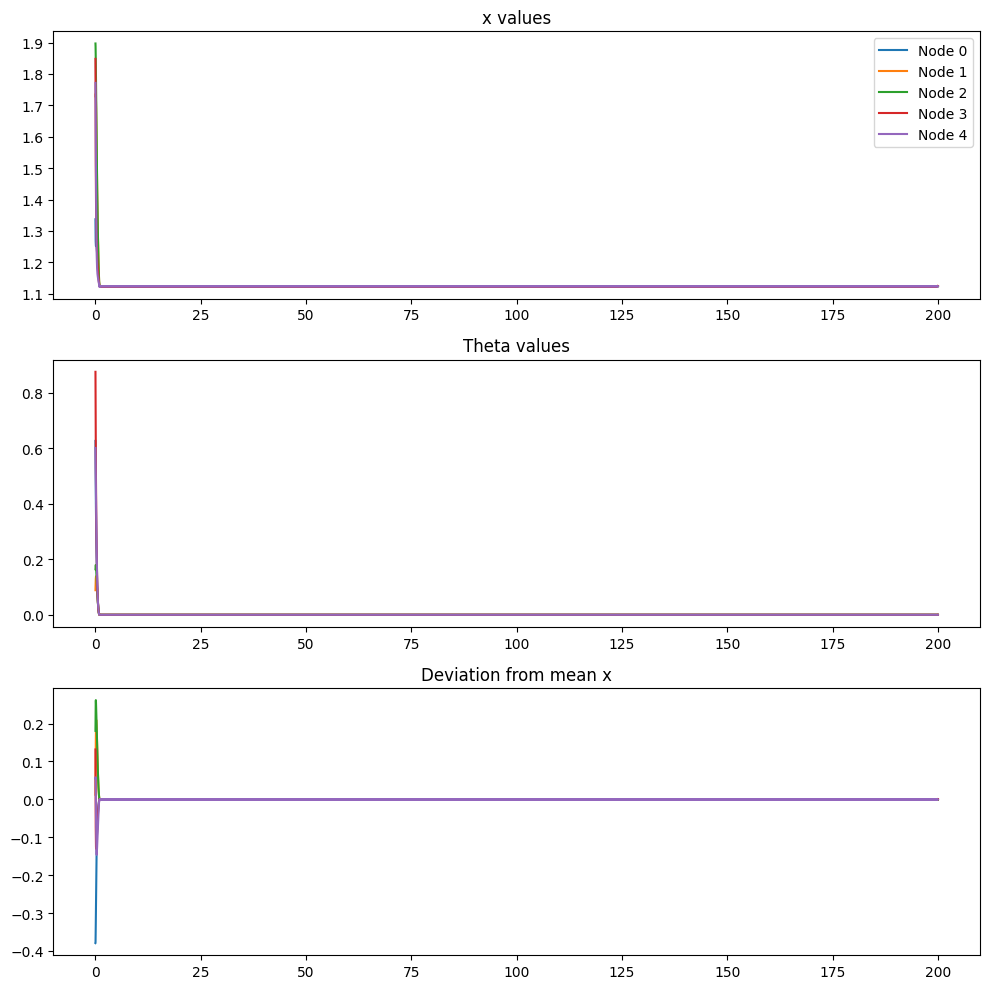

[[1.34920957 1.72595568 1.89711026 1.88708642 1.77987555]
 [1.33708981 1.72857522 1.8970013  1.84793991 1.77139853]
 [1.32612551 1.7308038  1.89608344 1.81151468 1.7623517 ]
 ...
 [1.12360964 1.12436141 1.1235378  1.12434482 1.12375804]
 [1.12429389 1.12354212 1.12436573 1.12355871 1.12414549]
 [1.12360964 1.12436141 1.1235378  1.12434482 1.12375804]]


np.float64(0.0003588642911943154)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig

# Create a ring graph with 5 nodes
g = ig.Graph.Ring(5, directed=False)
A = np.array(g.get_adjacency().data, dtype=float)

# Parameters
gamma = 0.5
delta = 0.3
N = g.vcount()
T = 200.0
dt = 0.005
num_steps = int(T / dt)
time = np.linspace(0, T, num_steps)
x = np.random.uniform(low=1, high=2, size=N)
theta = np.random.uniform(low=0, high=1, size=N)

# Store history
x_hist = [x.copy()]
theta_hist = [theta.copy()]

# sgn function with fractional power
def sgn_power(val, power):
    return np.sign(val) * np.abs(val) ** power

# Simulation loop
for t in range(num_steps):
    omega = np.zeros(N)
    for i in range(N):
        for j in g.neighbors(i):
            omega[i] += (sgn_power(theta[j] - theta[i], 1) +
                         gamma * sgn_power(theta[j] - theta[i], 0.5) +
                         delta * sgn_power(theta[j] - theta[i], 1.5))

    h = - (theta + sgn_power(theta, 0.5) + sgn_power(theta, 1.5))
    theta_dot = omega + h
    theta += dt * theta_dot

    g_i = -theta_dot + sgn_power(theta_dot, 0.5) + sgn_power(theta_dot, 1.5)
    u_i = np.zeros(N)
    for i in range(N):
        for j in g.neighbors(i):
            u_i[i] += -sgn_power(x[i] - x[j], 0.5) - sgn_power(x[i] - x[j],1.5)

    x_dot = g_i + u_i
    x += dt * x_dot

    x_hist.append(x.copy())
    if np.std(x_hist[-1]) < 1e-5:
      break
    theta_hist.append(theta.copy())

x_hist = np.array(x_hist)
theta_hist = np.array(theta_hist)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in range(N):
    axs[0].plot(time, x_hist[1:, i], label=f'Node {i}')
axs[0].set_title("x values")
axs[0].legend()

for i in range(N):
    axs[1].plot(time, theta_hist[1:, i], label=f'Node {i}')
axs[1].set_title("Theta values")

for i in range(N):
    axs[2].plot(time, x_hist[1:, i] - np.mean(x_hist[1:], axis=1), label=f'Node {i}')
axs[2].set_title("Deviation from mean x")
plt.tight_layout()
plt.show()
print (x_hist)
np.std(x_hist[-1])


In [18]:
np.std(x_hist[-10:])


np.float64(0.0006277404375976087)